# Imports

In [18]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import re, string

import seaborn as sns


# Data

In [2]:
df = pd.read_csv("upsampled_df.csv")

In [3]:
df.head()

,Unnamed: 0,score,Text,sentiment,Id
0,0,1,ZUKA ZAMA! 🇺🇸🇺🇸🇺🇸❤️🤍💙,Positive,1
1,1,1,Zip ties!,Positive,2
2,2,1,Zero sugar options would be nice as well,Positive,3
3,3,1,Zendaya by cozz ft. J Cole 🐐,Positive,4
4,4,1,Zayunmmmm who are these people 🥵😍,Positive,5


In [4]:
df['target'] =df['score']

In [5]:
df['target']=df['target'].astype('category')

We have two classes in the dataset

In [6]:
df.target.unique()

[1, 0]
Categories (2, int64): [0, 1]

Let's check how equally distributed those classes are.

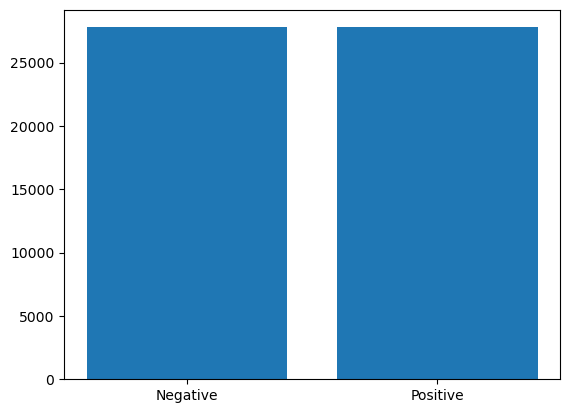

In [7]:
classes = df.target.unique()
counts = []

for i in classes:
  count = len(df[df.target==i])
  counts.append(count)

plt.bar(['Negative', 'Positive'], counts)
plt.show()

## Data cleaning

In [8]:
# Some basic helper functions to clean text by removing urls, emojis, html tags and punctuations.

def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)


def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text


def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)



def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Applying helper functions
# Applying helper functions

In [9]:
df['Text'] = df['Text'].apply(func= remove_emoji)
df['Text'] = df['Text'].apply(func= strip_links)
df['Text'] = df['Text'].apply(func= strip_all_entities)
df['Text'] = df['Text'].apply(func= remove_punct)
df['Text'] = df['Text'].str.lower()

Even class distribution helps us a lot in text classifiction. Imagine a situation where 95% of data is in one class and the rest 5% is split among other 5 classes. If we wouldn't do anything about it model would just learn to guess the 95% class all the time and would be correct 95% of the time on the data we would use.

# Vectorize
What we need to do now is to split the data into training and testing datasets and vectorize (essentialy turning text into number vectors) the text. 

In [10]:
x = df.Text.values
y = df.target.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=32)

Vectorizing

In [11]:
vectorizer = CountVectorizer()
vectorizer.fit(x_train)

X_train = vectorizer.transform(x_train)
X_test = vectorizer.transform(x_test)

Our vectorized dataset will consist of index of each word that is used in training dataset. We can check how it looks by simply printing the first tweet both as it was and after vectorizing it.

In [12]:
print(x_train[0], '\n', X_train[0])

no i’m not i messaged a few ppl to see if anyone can go in for me 
   (0, 914)	1
  (0, 2079)	1
  (0, 4481)	1
  (0, 4660)	1
  (0, 5040)	1
  (0, 5818)	1
  (0, 5891)	1
  (0, 7342)	1
  (0, 7457)	1
  (0, 8047)	1
  (0, 8100)	1
  (0, 8991)	1
  (0, 10215)	1
  (0, 11819)	1


Now the sparse matrix you see corresponds to index of the word and count of it in the tweet. Keep in mind it's not in the same order as in the tweet. You can check the corresponding values using vocabulary of the vectorizer.

# Modelling
The model that we use here is a simple [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression). 

In [13]:
classifier = LogisticRegression(max_iter=20000)
classifier.fit(X_train, y_train)

score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.95979492714517


#Confussion matrix
Before jumping into other models it's always good to check how our model performs in different classes. For that we can use [confussion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).

It essentially shows how many times model predicted which class and how many of those times the class it slected was the right one. Here columns are true values and lines are predicted values.

# Test

In [14]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=df.target.unique())
df_cm = pd.DataFrame(cm, index=df.target.unique(), columns=df.target.unique())
df_cm

,1,0
1,5245,360
0,87,5426


In [15]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[5426   87]
 [ 360 5245]]


For a better understanding you could use percentage expression.

<AxesSubplot:>

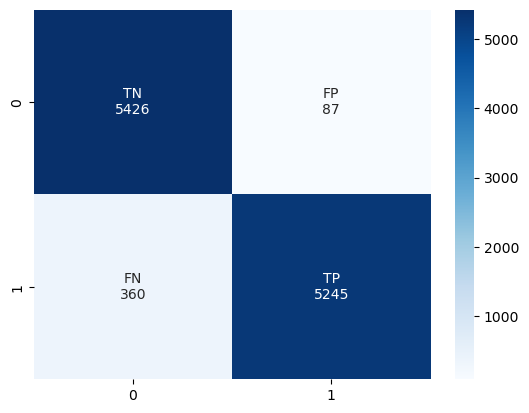

In [21]:
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks


    box_labels = [f"{v1}{v2}".strip() for v1, v2 in zip(group_labels,group_counts)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)


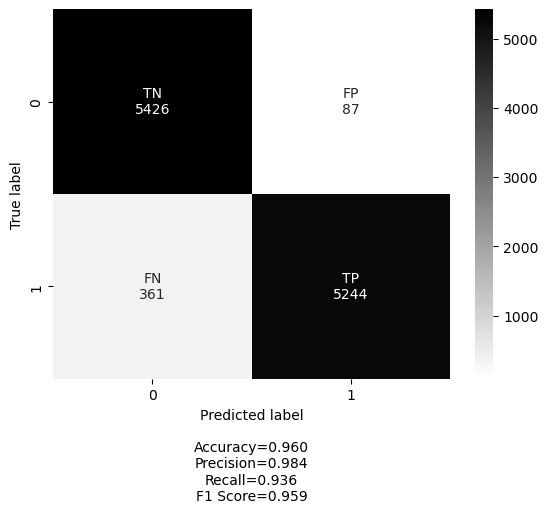

In [48]:
labels = ['TN','FP','FN','TP']
categories = ["0", "1"]
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')

In [23]:
cm = confusion_matrix(y_test, y_pred, labels=df.score.unique())
df_cm = pd.DataFrame(cm, index=df.score.unique(), columns=df.score.unique())
df_cm

df_cm_percentage = df_cm.copy()
for i in df_cm_percentage:
  df_cm_percentage[i]/=df_cm_percentage[i].sum()

df_cm_percentage

,1,0
1,0.983683,0.062219
0,0.016317,0.937781


In [24]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.98      0.96      5513
           1       0.98      0.94      0.96      5605

    accuracy                           0.96     11118
   macro avg       0.96      0.96      0.96     11118
weighted avg       0.96      0.96      0.96     11118



Good, so in the end model learnt to classify both classes about the same. Even though we are using Logistic Regression as a base measure to check if the problem is solvable and what results we might expect some insights can be derived here:

1.   Classes are evenly distributed, thus we won't overtrain on one class compared to the other

2.   Both classes are predicted equally well



Now we need to check if it actually works. Let's just copy a comment in one of Trump's [tweets](https://twitter.com/realDonaldTrump/status/1315835556081868801). 

The comment is: 
PATRIOTIC AMERICANS STAND PROUDLY WITH PRESIDENT TRUMP!!

In [25]:
tweet = 'PATRIOTIC AMERICANS STAND PROUDLY WITH PRESIDENT TRUMP!!'
vectTweet = vectorizer.transform(np.array([tweet]))  # vectorizes the tweet using our vectorizer

prediction = classifier.predict(vectTweet)  # predicts class of the tweet
print('Tweet is', 'positive' if prediction[0]==1 else 'negative')

Tweet is positive


Good, so our model is right here. Let's just make sure our model works okay with very specific sentiments.

In [26]:
tweetList = ['Best tweet ever!', 'Mondays are the worst...']
vectTweet = vectorizer.transform(np.array(tweetList))  # vectorizes the tweet using our vectorizer

prediction = classifier.predict(vectTweet)  # predicts class of the tweet
for enum, i in enumerate(tweetList):
  print(i, '| This tweet is', 'positive' if prediction[enum]==1 else 'negative')

Best tweet ever! | This tweet is positive
Mondays are the worst... | This tweet is negative
